In [192]:
from tensorflow.keras import layers, models 
from tensorflow.keras.models import load_model
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from keras.callbacks import TensorBoard
import datetime
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler();


In [2]:
import json
import csv

# Read JSON data from a file
json_file_path = "lichess_db_eval.json"
with open(json_file_path, "r") as file:
    # Read each line separately
    json_lines = file.readlines()

# Create CSV file
csv_file_path = "output.csv"
with open(csv_file_path, mode="w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    
    # Write header
    writer.writerow(["FEN", "Eval Score"])

    # Parse each JSON line
    for json_data in json_lines:
        try:
            # Parse JSON data
            data = json.loads(json_data)

            # Extract FEN
            fen = data["fen"]

            # Extract eval scores
            eval_scores = []
            for pv in data["evals"]:
                if "cp" in pv["pvs"][0]:
                    eval_scores.append(pv["pvs"][0]["cp"])
                elif "cp" in pv:
                    eval_scores.append(pv["cp"])
                else:
                    continue

            # Write data
            for eval_score in eval_scores:
                writer.writerow([fen, eval_score])

        except json.JSONDecodeError as e:
            print(f"Error decoding JSON: {e}")

print(f"Data has been saved to {csv_file_path}.")


Data has been saved to output.csv.


In [274]:
df = pd.read_csv("output.csv", nrows=100000)
df["FEN"][22]



'rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR b KQkq -'

In [275]:

fens = df["FEN"].tolist()
evaluation_scores = df["Eval Score"].tolist()
df["Eval Score"][22]

37

In [276]:
def fen_to_combined_input(fen):
    board , turn ,castling   = fen.split()[:3] 

    board_matrix = np.zeros((8,8,12),dtype=np.int8)
    piece_map = {'P': 0, 'N': 1, 'B': 2, 'R': 3, 'Q': 4, 'K': 5,
               'p': 6, 'n': 7, 'b': 8, 'r': 9, 'q': 10, 'k': 11}
    
    for i, row in enumerate(board.split("/")):
        for j,char in enumerate(row):
            if char in piece_map:
                board_matrix[i,j, piece_map[char]] =1
            else:
                board_matrix[i,j,:] =12    

    turn_vector = np.zeros(2, dtype=np.int8)
    turn_vector[0 if turn == "w" else 1] = 1

  # Castling options representation (4-bit binary)
    castling_bits = 0
    for char in castling:
        if char in "KQkq":
            castling_bits |= 1 << (ord(char) - ord("K"))

  # Combine representations
    combined_input = np.concatenate((board_matrix.flatten(), turn_vector, np.array([castling_bits])), axis=0)

    return combined_input            

In [277]:
input_tensors= []
for fen in fens:
    board_matrix = fen_to_combined_input(fen)[:768].reshape(8, 8, 12)  # Generate input tensors using your function
    input_tensors.append(board_matrix)
    #plt.imshow(board_matrix.max(axis=2), cmap='gray')
    #plt.show()      

In [320]:
input_tensors = np.asarray(input_tensors)

In [533]:

# Input layer (matching board matrix shape)
inputs = tf.keras.Input(shape=(8, 8, 12))

# Convolutional layers (adjust as needed)
x = tf.keras.layers.Conv2D(256, 4, activation='relu')(inputs)
x = tf.keras.layers.Conv2D(128, 4, activation='relu')(x)


#Pooling layer
#x = tf.keras.layers.MaxPooling2D(2)(x)

# Flatten layer
x = tf.keras.layers.Flatten()(x)

# Fully connected layers
x = tf.keras.layers.Dense(32)(x)

# Output layer (single neuron for regression)
outputs = tf.keras.layers.Dense(1 , activation = 'relu' )(x)

# Create the model
model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(loss='mae', optimizer='adam')

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler();

X_train, X_test, y_train, y_test = train_test_split(input_tensors, evaluation_scores, test_size=0.2)
y_train = np.asarray(y_train)

X_train_normalized = scaler.fit_transform(X_train.reshape(-1, 8 * 8 * 12)).reshape(-1, 8, 8, 12)
X_test_normalized = scaler.transform(X_test.reshape(-1, 8 * 8 * 12)).reshape(-1, 8, 8, 12)


y_train_normalized = scaler .fit_transform(y_train.reshape(-1, 1))

#softmax loss function note

In [534]:
log_dir = "logs/fit/"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=2,)


In [535]:
#model.fit(X_train, y_train_normalized, epochs=10 ,batch_size=64)
model.fit(X_train_normalized, y_train_normalized, epochs=50, batch_size=256, callbacks=[tensorboard_callback])

Epoch 1/50
32/32 [==============================] - 1s 24ms/step - loss: 0.1930
Epoch 2/50
32/32 [==============================] - 1s 16ms/step - loss: 0.0190
Epoch 3/50
32/32 [==============================] - 1s 17ms/step - loss: 0.0130
Epoch 4/50
32/32 [==============================] - 0s 15ms/step - loss: 0.0129
Epoch 5/50
32/32 [==============================] - 1s 19ms/step - loss: 0.0108
Epoch 6/50
32/32 [==============================] - 1s 18ms/step - loss: 0.0098
Epoch 7/50
32/32 [==============================] - 1s 19ms/step - loss: 0.0097
Epoch 8/50
32/32 [==============================] - 1s 17ms/step - loss: 0.0120
Epoch 9/50
32/32 [==============================] - 1s 19ms/step - loss: 0.0114
Epoch 10/50
32/32 [==============================] - 0s 14ms/step - loss: 0.0114
Epoch 11/50
32/32 [==============================] - 1s 18ms/step - loss: 0.0098
Epoch 12/50
32/32 [==============================] - 1s 16ms/step - loss: 0.0086
Epoch 13/50
32/32 [==================

In [466]:
#tensorboard --logdir logs/fit


In [536]:
#model.save("/Users/zimjanmol/Desktop/Chess-Engine/ChessEngineSolution/ChessEngine/dumb2.keras")
model.save("/Users/zimjanmol/Desktop/Chess-Engine/NN/TestedLast.keras")

In [537]:
#from keras.models import load_model
keras_model = load_model("TestedLast.keras")

# Print the names of all layers in the model
for layer in keras_model.layers:
    print(layer.name)

input_50
conv2d_98
conv2d_99
max_pooling2d_43
flatten_49
dense_98
dense_99


63/63 [==============================] - 0s 3ms/step


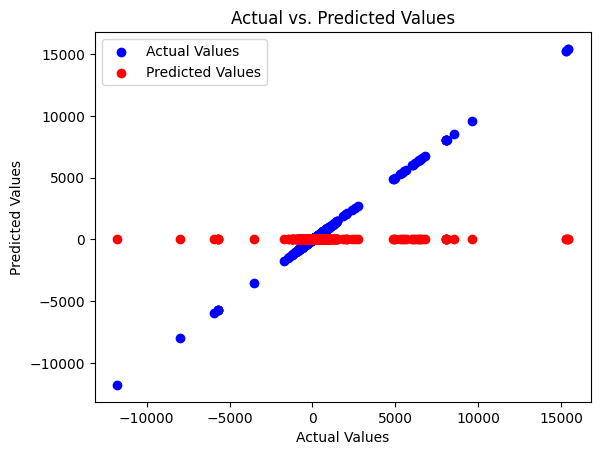

In [538]:
y_pred = keras_model.predict(X_test)
y_pred

import matplotlib.pyplot as plt

# Assuming y_test and y_pred are your actual and predicted values

plt.scatter(y_test, y_test, color='blue', label='Actual Values')
plt.scatter(y_test, y_pred, color='red', label='Predicted Values')

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.legend()  # Add a legend to the plot

plt.show()


In [539]:
#Metrics 
from sklearn.metrics import mean_squared_error, mean_absolute_error
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae:.4f}')

Mean Absolute Error: 245.9654


In [506]:
# Assume 'fen_string' is the FEN string you want to predict"
fen_string = "rnbqkbnr/qqqppppp/8//8/PPPPPPPP/RNB1KBNR b KQkq -"


def GetEval():
    # Convert FEN string to the model input format
    input_tensor = fen_to_combined_input(fen_string)[:768].reshape(8, 8, 12)

    # Reshape the input tensor to match the model's input shape
    input_tensor = np.expand_dims(input_tensor, axis=0)

    # Make a prediction using the trained model
    predicted_evaluation = keras_model.predict(input_tensor)

    return predicted_evaluation[0][0]

    # Print the predicted evaluation score
    #print("Predicted Evaluation:", predicted_evaluation[0][0])



In [500]:
GetEval()


1/1 [==============================] - 0s 14ms/step


0.7184607